In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import piv_fun as piv
import pof_piv as piv_old
import cv2 as cv
from numba import njit

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
margins_all = [[48, 496-443, 0, 0], 
           [60, 496-452, 0, 0],
           [10, 496-480, 0, 0],
           [0, 0, 128, 0]]

In [ ]:
nr_position = 4
nr_series = 4
directory = 'piv_examples/pos' + str(nr_position) + '-' + str(nr_series) + '/'


margins = margins_all[nr_position - 1]

frame_rate = 40000
max_shift_px = 100
hor_slices = 8
window_ct = (3, 32)
sum_rows = True
plot_flow_field = True
valid_angles = [np.pi / 4, 3 * np.pi / 4]

# Load a few example images
images = piv.read_image_directory(directory, image_type='tif')

# Load background
background = cv.imread('data/backgrounds/pos' + str(nr_position) + '-' + str(nr_series) + '.tif', cv.IMREAD_GRAYSCALE)

piv.optical_flow(images, 8, (24, 32), 100, margins=margins, sum_rows=True, background=background, do_flow_plot=True, valid_angles=valid_angles)

In [49]:
images_video = piv.read_image_directory('data/pos4-4', image_type='tif', timing=True)
background = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Set options
nr_position = 4 
max_shift_px = 100
slice_ct = 8
window_ct = (24, 32)

# From array
margins = margins_all[nr_position - 1]

# Run PIV
displacements, window_centers = piv.optical_flow(images_video, slice_ct, window_ct, max_shift_px, use_guess=True,
                                 margins=margins, sum_rows=False, background=background,
                                 valid_angles=[np.pi / 4, 3 * np.pi / 4],
                                 timing=True)

Optical flow: 100%|██████████| 20994/20994 [35:45<00:00,  9.78it/s]


(0.0, 2000.0)

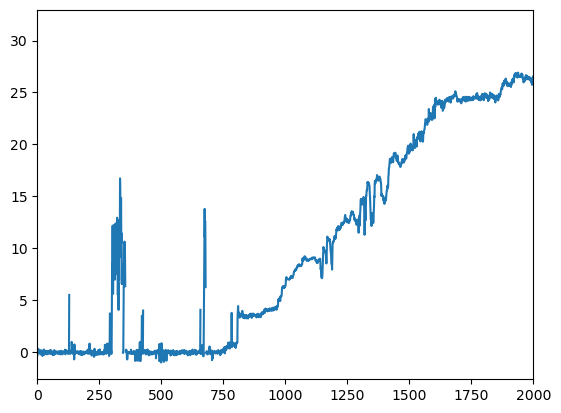

In [52]:
# Calculate the mean displacement
mean_displacements = piv.mean_displacement(displacements, comp='x', av_dir='all')

# Plot the mean displacement over time
fig, ax = plt.subplots()
ax.plot(mean_displacements.flatten())
ax.set_xlim(0, 2000)

Optical flow: 100%|██████████| 750/750 [00:46<00:00, 15.98it/s]


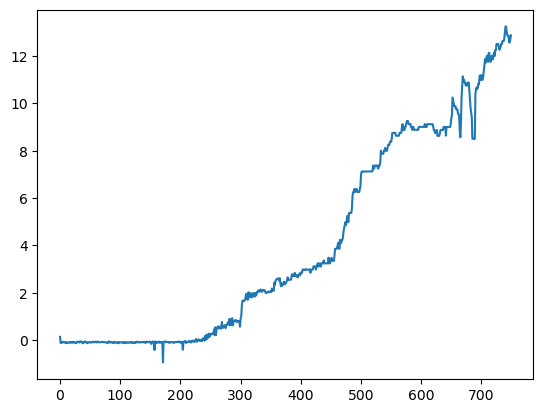

In [33]:
images_video = piv.read_image_directory('data/pos4-4', image_type='tif', timing=True, file_range=(500, 1250))
background = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Set options
nr_position = 4
max_shift_px = 100
slice_ct = 8
window_ct = (24, 32)

# From array
margins = margins_all[nr_position - 1]

# Run PIV
displacements, window_centers = piv.optical_flow(images_video, slice_ct, window_ct, max_shift_px, use_guess=True,
                                 margins=margins, sum_rows=True, background=background,
                                 valid_angles=[np.pi / 4, 3 * np.pi / 4],
                                 timing=True)

# Calculate the mean displacement
mean_displacements = piv.mean_displacement(displacements, comp='x', av_dir='all')

# Plot the mean displacement over time
fig, ax = plt.subplots()
ax.plot(mean_displacements.flatten())
# ax.set_xlim(0, 2000)
# ax.set_ylim(0, 35)

Optical flow: 100%|██████████| 1500/1500 [01:31<00:00, 16.47it/s]


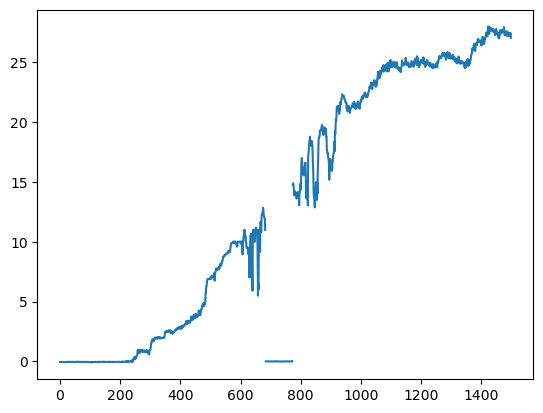

In [18]:
images_video = piv.read_image_directory('data/pos4-4', image_type='tif', timing=True, file_range=(1100, 1250))
background = cv.imread('data/backgrounds/pos4-4.tif', cv.IMREAD_GRAYSCALE)

# Set options
nr_position = 1
max_shift_px = 100
slice_ct = 8
window_ct = (24, 32)

# From array
margins = margins_all[nr_position - 1]

# Run PIV
displacements, window_centers = piv.optical_flow(images_video, slice_ct, window_ct, max_shift_px, use_guess=True,
                                 margins=margins, sum_rows=True, background=background,
                                 valid_angles=[np.pi / 4, 3 * np.pi / 4],
                                 timing=True)

# Calculate the mean displacement
mean_displacements = piv.mean_displacement(displacements, comp='x', av_dir='all')

# Plot the mean displacement over time
fig, ax = plt.subplots()
ax.plot(mean_displacements.flatten())
# ax.set_xlim(0, 2000)
# ax.set_ylim(0, 35)